In [18]:

    # READ DATA


In [2]:
import chess
import numpy as np
import pandas as pd
import numexpr as ne
import swifter
import statsmodels.api as sm
import pylab

C:\Users\mehra\.julia\conda\3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
df = pd.read_csv("./random_evals.csv")
df.head(10)

,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209
5,rnbqkb1r/pppppppp/5n2/8/2B1P3/8/PPPP1PPP/RNBQK...,-101
6,rnbqkb1r/pppppppp/5n2/8/4P3/5N2/PPPP1PPP/RNBQK...,-105
7,rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPPNPPP/RNBQKB1...,-136
8,rnbqkb1r/pppppppp/5n2/7Q/4P3/8/PPPP1PPP/RNB1KB...,-1262
9,rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPPBPPP/RNBQK1N...,-117


In [6]:

    # PROCESS EVAL


In [7]:
df['EvaluationStr'] = df['Evaluation'].astype(str)

In [8]:
df.loc[df['EvaluationStr'].str.contains("#-", na=False), 'EvaluationStr'] = -31800
df.loc[df['EvaluationStr'].str.contains("#+", na=False), 'EvaluationStr'] = 31800

In [9]:
df['Evaluation'] = df['EvaluationStr'].astype(int) / 100

In [10]:

    # CONVERT EVAL to WIN PROB


In [11]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1. - s)

def chessmoid(x):
    return sigmoid(0.9 * x)
def chessmoid_derivative(x):
    # chessmoid'(x) = sigmoid'(0.9 * x) * 0.9
    return sigmoid_derivative(0.9 * x) * 0.9

In [12]:
df['Prob'] = np.vectorize(chessmoid)(df['Evaluation'])

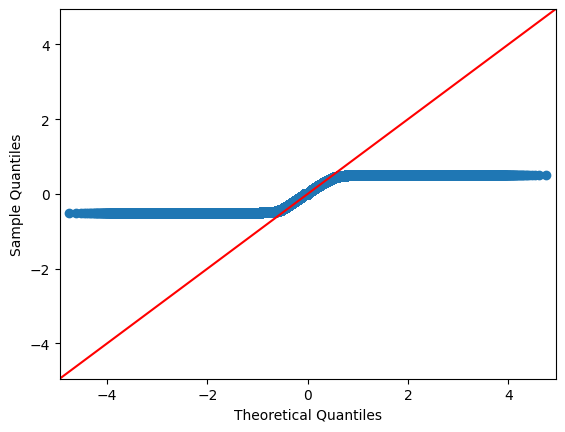

In [14]:
# u = np.mean(df['Evaluation'])
# o = np.std(df['Evaluation'])
tr = df['Prob'] - 0.5

sm.qqplot(tr, line='45')
pylab.show()

In [15]:

    # PARSE BOARD


In [16]:
def fen_to_board(x):
    return chess.Board(x)

def board_to_bools(board):
    arr = np.zeros(389, dtype=int)
    idx = 0

    for pc in range(1, 6 + 1):
        BB_B = int(board.pieces(pc, chess.BLACK))
        BB_W = int(board.pieces(pc, chess.WHITE))
        for i in range(0, 64):
            arr[idx + i] = ((BB_W >> i) & 1) - ((BB_B >> (i ^ 56)) & 1)
        idx += 64

    arr[idx + 0] = bool(board.castling_rights & chess.BB_H1)
    arr[idx + 1] = bool(board.castling_rights & chess.BB_A1)
    arr[idx + 2] = bool(board.castling_rights & chess.BB_H8)
    arr[idx + 3] = bool(board.castling_rights & chess.BB_A8)
    arr[idx + 4] = board.turn
    
    return arr

def board_to_hist(board):
    arr = np.zeros(5, dtype=int)
    idx = 0

    for pc in range(1, 5 + 1):
        BB_B = len(board.pieces(pc, chess.BLACK))
        BB_W = len(board.pieces(pc, chess.WHITE))
        arr[idx] = BB_W - BB_B
        idx += 1
    
    return arr

In [ ]:
df['Board'] = df['FEN'].swifter.apply(fen_to_board)

In [ ]:
df['Bits'] = df['Board'].swifter.apply(board_to_bools)

In [ ]:
df['Hist'] = df['Board'].swifter.apply(board_to_hist)

In [ ]:
df_saved = df.copy()
df_saved = df_saved.drop(columns=['Board'])
df_saved.to_parquet('random_evals_processed.parquet')